In [1]:
# Load Packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Normalization

import model_prep

datapath = "../data"

2023-06-16 09:37:41.942405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h1 style="color:#27469c">ESB Cooling Tower 1 - Summer Data</h1>

In [2]:
step_back = 6 # window size = 6*5 = 30 mins

<h2 style="color:#27469c">1. Create timestepped data on pandas and normalize</h2>

In [3]:
# load data
df = pd.read_csv(f'{datapath}/esb/esb_tower_1_preprocessed.csv', index_col='time')
df.index = pd.to_datetime(df.index)

# only take data for one season
df = model_prep.choose_season(df, season='summer', season_col_name='ESB_Tower_1 season')

# save a boolean series that specifies whether the cooling tower is on
on_condition = df['ESB_Tower_1 fanStatus']

# select features and targets and create final dataframe that includes only relevant features and targets
features = ['ESB_Tower_1 enteringWaterTemp', 'ESB_Tower_1 outdoorAirHumidity', 'ESB_Tower_1 outdoorAirDryBulb', 'ESB_Tower_1 outdoorAirWetBulb', 'Cell_1aFan vfdPower', 'Cell_1bFan vfdPower']
target = 'ESB_Tower_1 leavingWaterTemp'
df = df[features].join(df[target], on=df.index)

# normalize data
scaler = model_prep.NormalizationHandler()
df = scaler.normalize(dtframe=df, target_col=target)

# prepare dataframe for lstm by adding timesteps
lstm_df = model_prep.create_timesteps(df, n_in=step_back, n_out=1, target_name=target)

# remove cases where spring data would leak into summer data (i.e. intial timesteps)
lstm_df = model_prep.remove_irrelevant_data(lstm_df, on_condition, step_back)

# save
lstm_df.to_csv(f"{datapath}/esb/esb1_summer_timestepped.csv")

There are 25784 rows of data for the summer season.
Mininimum ESB_Tower_1 leavingWaterTemp = 0.0
Maximum ESB_Tower_1 leavingWaterTemp = 94.14920806884766
Number of samples in summer data before removing off times: 25784
 Number of samples in summer data after removing off times: 14346


<h2 style="color:#27469c">2. Split data into training and testing sets</h2>

In [4]:
tss = TimeSeriesSplit(n_splits = 3)
X = lstm_df.drop(f"{target}(t)", axis=1)  # drop target column
y = lstm_df[f"{target}(t)"]  # only have target column

for train_index, test_index in tss.split(X): # split into training and testing
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

<h2 style="color:#27469c">3. Get timestepped data as a 3D vector</h2>

In [5]:
vec_X_train = model_prep.df_to_3d(lstm_dtframe=X_train, num_columns=len(features)+1, step_back=step_back)
vec_X_test = model_prep.df_to_3d(lstm_dtframe=X_test, num_columns=len(features)+1, step_back=step_back)

vec_y_train = y_train.values
vec_y_test = y_test.values

print(vec_X_train.shape, vec_X_test.shape, vec_y_train.shape, vec_y_test.shape)

(10760, 6, 7) (3586, 6, 7) (10760,) (3586,)


<h2 style="color:#27469c">4. Create and Train model</h2>

In [6]:
model = Sequential()
model.add(LSTM(50, input_shape=(vec_X_train.shape[1], vec_X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(vec_X_train, vec_y_train, epochs=50, batch_size=72, validation_data=(vec_X_test, vec_y_test), verbose=0, shuffle=False)

2023-06-16 09:37:46.466252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


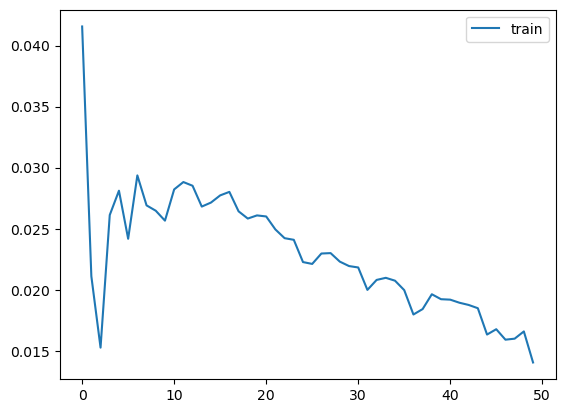

In [7]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [8]:
yhat = model.predict(vec_X_test)

113/113 [==============================] - 0s 1ms/step


<h2 style="color:#27469c">5. Display results</h2>

In [30]:
results_df = pd.DataFrame({'actual': vec_y_test.reshape((vec_y_test.shape[0])), 'predicted': yhat.reshape((yhat.shape[0]))}, index=y_test.index)
results_df = scaler.denormalize_results(results_df)

# Create a new DataFrame with the desired 5-minute interval index
new_index = pd.date_range(start=results_df.index.min(), end=results_df.index.max(), freq='5min')
display_df = pd.DataFrame(index=new_index)
# Merge the new DataFrame with the original DataFrame
display_df = display_df.merge(results_df, how='left', left_index=True, right_index=True)

fig = px.line(display_df, x=display_df.index, y=["actual", "predicted"])
fig.update_layout(
    title="ESB Tower 1 LSTM Model Results",
    xaxis_title="time",
    yaxis_title=target
)
fig.show()
fig.write_html("../plots/esb1_summer_lstm.html")

In [31]:
model.summary()
model.save('../models_saved/esb1_summer_lstm/')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                11600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 11,651
Trainable params: 11,651
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: ../models_saved/esb1_summer_lstm/assets


INFO:tensorflow:Assets written to: ../models_saved/esb1_summer_lstm/assets
